# Car Price Prediction
## Exploratory Data Analysis

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, concat_ws, when
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import matplotlib.style as style
import warnings

In [5]:
warnings.filterwarnings('ignore')
spark = SparkSession.builder.appName('CarPricePedictions').getOrCreate()

In [6]:
# read the dataset
carData = spark.read.option("header", "true").csv("car_price_dataset.csv")

In [7]:
# check the data types
carData.describe()

DataFrame[summary: string, Brand: string, Model: string, Year: string, Engine_Size: string, Fuel_Type: string, Transmission: string, Mileage: string, Doors: string, Owner_Count: string, Price: string]

In [8]:
# convert the data types to the apporiate ones
integerCols = ["Year", "Mileage", "Doors", "Owner_Count"]
carData = carData.select([col(c).cast(IntegerType()).alias(c) if c in integerCols else col(c) for c in carData.columns])


doubleCols = ["Engine_Size", "Price"]
carData = carData.select([col(c).cast(DoubleType()).alias(c) if c in doubleCols else col(c) for c in carData.columns])

In [9]:
# get a preview of the dataset
carData.show(5)

+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-------+
|     Brand| Model|Year|Engine_Size|Fuel_Type|  Transmission|Mileage|Doors|Owner_Count|  Price|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-------+
|       Kia|   Rio|2020|        4.2|   Diesel|        Manual| 289944|    3|          5| 8501.0|
| Chevrolet|Malibu|2012|        2.0|   Hybrid|     Automatic|   5356|    2|          3|12092.0|
|  Mercedes|   GLA|2020|        4.2|   Diesel|     Automatic| 231440|    4|          2|11171.0|
|      Audi|    Q5|2023|        2.0| Electric|        Manual| 160971|    2|          1|11780.0|
|Volkswagen|  Golf|2003|        2.6|   Hybrid|Semi-Automatic| 286618|    3|          3| 2867.0|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-------+
only showing top 5 rows



In [10]:
# check for missing data
carData.select([sum(col(c).isNull().cast("int")).alias(c) for c in carData.columns]).show()

+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+
|Brand|Model|Year|Engine_Size|Fuel_Type|Transmission|Mileage|Doors|Owner_Count|Price|
+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+
|    0|    0|   0|          0|        0|           0|      0|    0|          0|    0|
+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+



In [11]:
# check for duplicated data
initalObservationCount = carData.count()
uniqueObservationCount = carData.distinct().count()

duplicateCount = initalObservationCount - uniqueObservationCount
print("Number of Duplicates: " + str(duplicateCount))

Number of Duplicates: 0


In [12]:
# get an overview of the data
carData.summary().show()

+-------+----------+--------+-----------------+------------------+---------+--------------+-----------------+-----------------+------------------+------------------+
|summary|     Brand|   Model|             Year|       Engine_Size|Fuel_Type|  Transmission|          Mileage|            Doors|       Owner_Count|             Price|
+-------+----------+--------+-----------------+------------------+---------+--------------+-----------------+-----------------+------------------+------------------+
|  count|     10000|   10000|            10000|             10000|    10000|         10000|            10000|            10000|             10000|             10000|
|   mean|      NULL|    NULL|        2011.5437|3.0005599999999966|     NULL|          NULL|      149239.1118|           3.4971|            2.9911|         8852.9644|
| stddev|      NULL|    NULL|6.897698756455926|1.1493240539456635|     NULL|          NULL|86322.34895733812|1.110096762215867|1.4226816904421142|3112.5968102892775|
|   

### Data Visualizations

#### Visualization of the Car Price

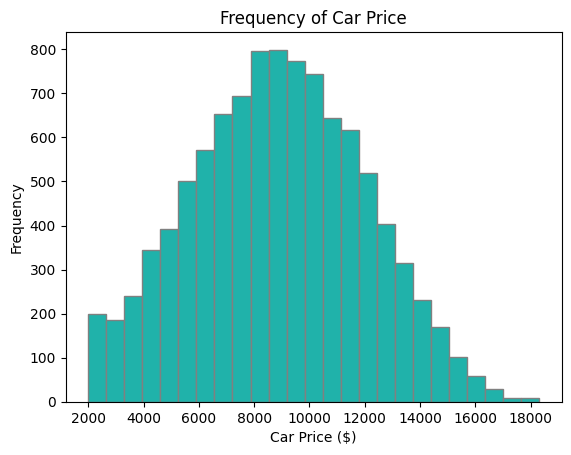

In [13]:
# define the histogram of car prices
carPriceHistogram = carData.select("Price").rdd.flatMap(lambda x: x).histogram(25)
binEdges, frequencies = carPriceHistogram

# plot the histogram
plt.hist(binEdges[:-1], bins=binEdges, weights=frequencies, color = "lightseagreen", edgecolor = "grey")
plt.xlabel("Car Price ($)")
plt.ylabel("Frequency")
plt.title("Frequency of Car Price")
plt.show()

#### Visualization of Quantitive Predictors

In [14]:
# collect the data
carDataCollect = carData.collect()

# define the target variable
carPrices = [row["Price"] for row in carDataCollect]

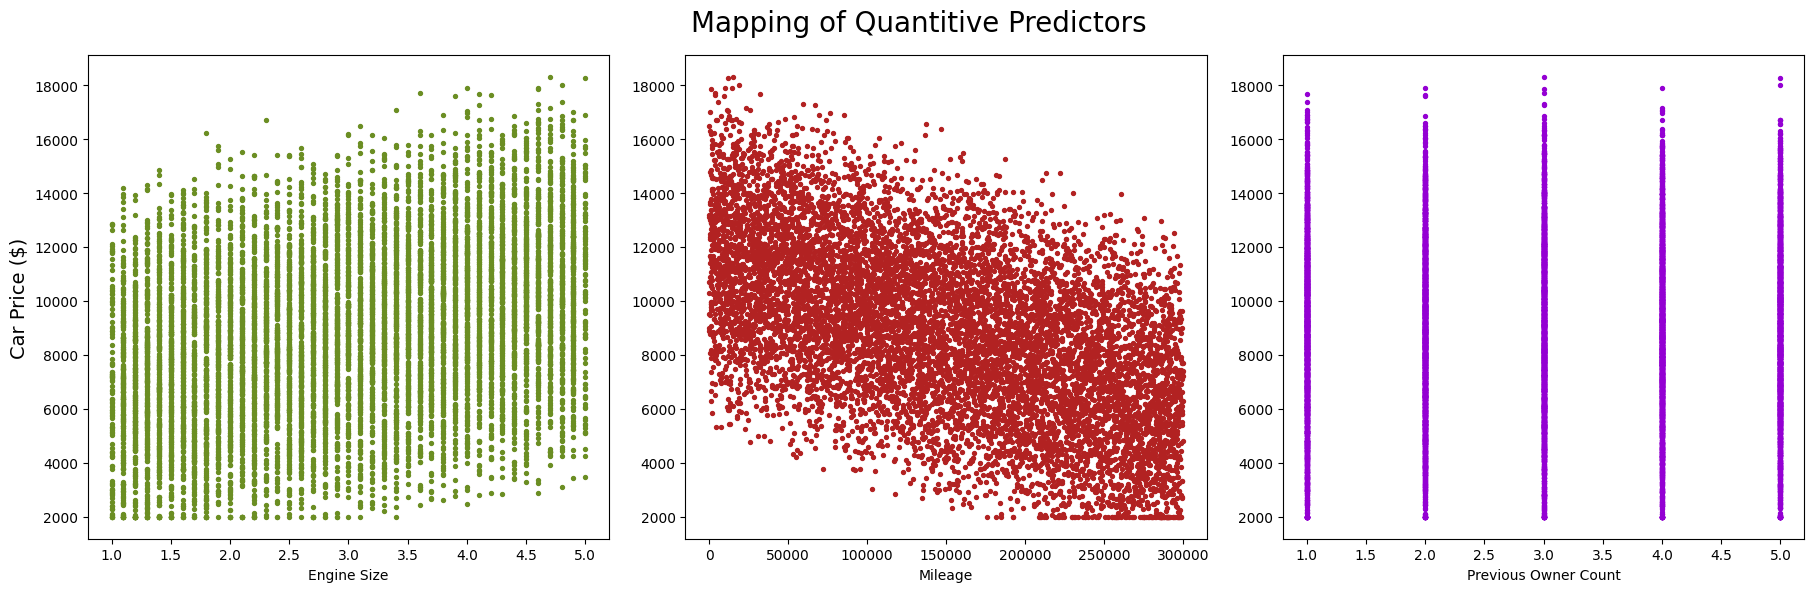

In [15]:
# collect the quantitive predictors
engineSize = [row["Engine_Size"] for row in carDataCollect]
mileage = [row["Mileage"] for row in carDataCollect]
ownerCount = [row["Owner_Count"] for row in carDataCollect]

# create a grid for multiple plots
fig, axs = plt.subplots(1, 3, figsize = (18, 6))

# plot a scatterplot of engine size
axs[0].scatter(engineSize, carPrices, s = 8, color = "olivedrab")
axs[0].set_xlabel("Engine Size")

# plot a scatterplot of mileage
axs[1].scatter(mileage, carPrices, s = 8, color = "firebrick")
axs[1].set_xlabel("Mileage")

# plot a scatterplot of owner count
axs[2].scatter(ownerCount, carPrices, s = 8, color = "darkviolet")
axs[2].set_xlabel("Previous Owner Count")



fig.suptitle("Mapping of Quantitive Predictors", fontsize = 20)
fig.text(0.0002, 0.5, "Car Price ($)", ha= "center", va= "center", rotation= "vertical", fontsize=14)

plt.tight_layout()
plt.show()

#### Visualization of Qualitative Predictors

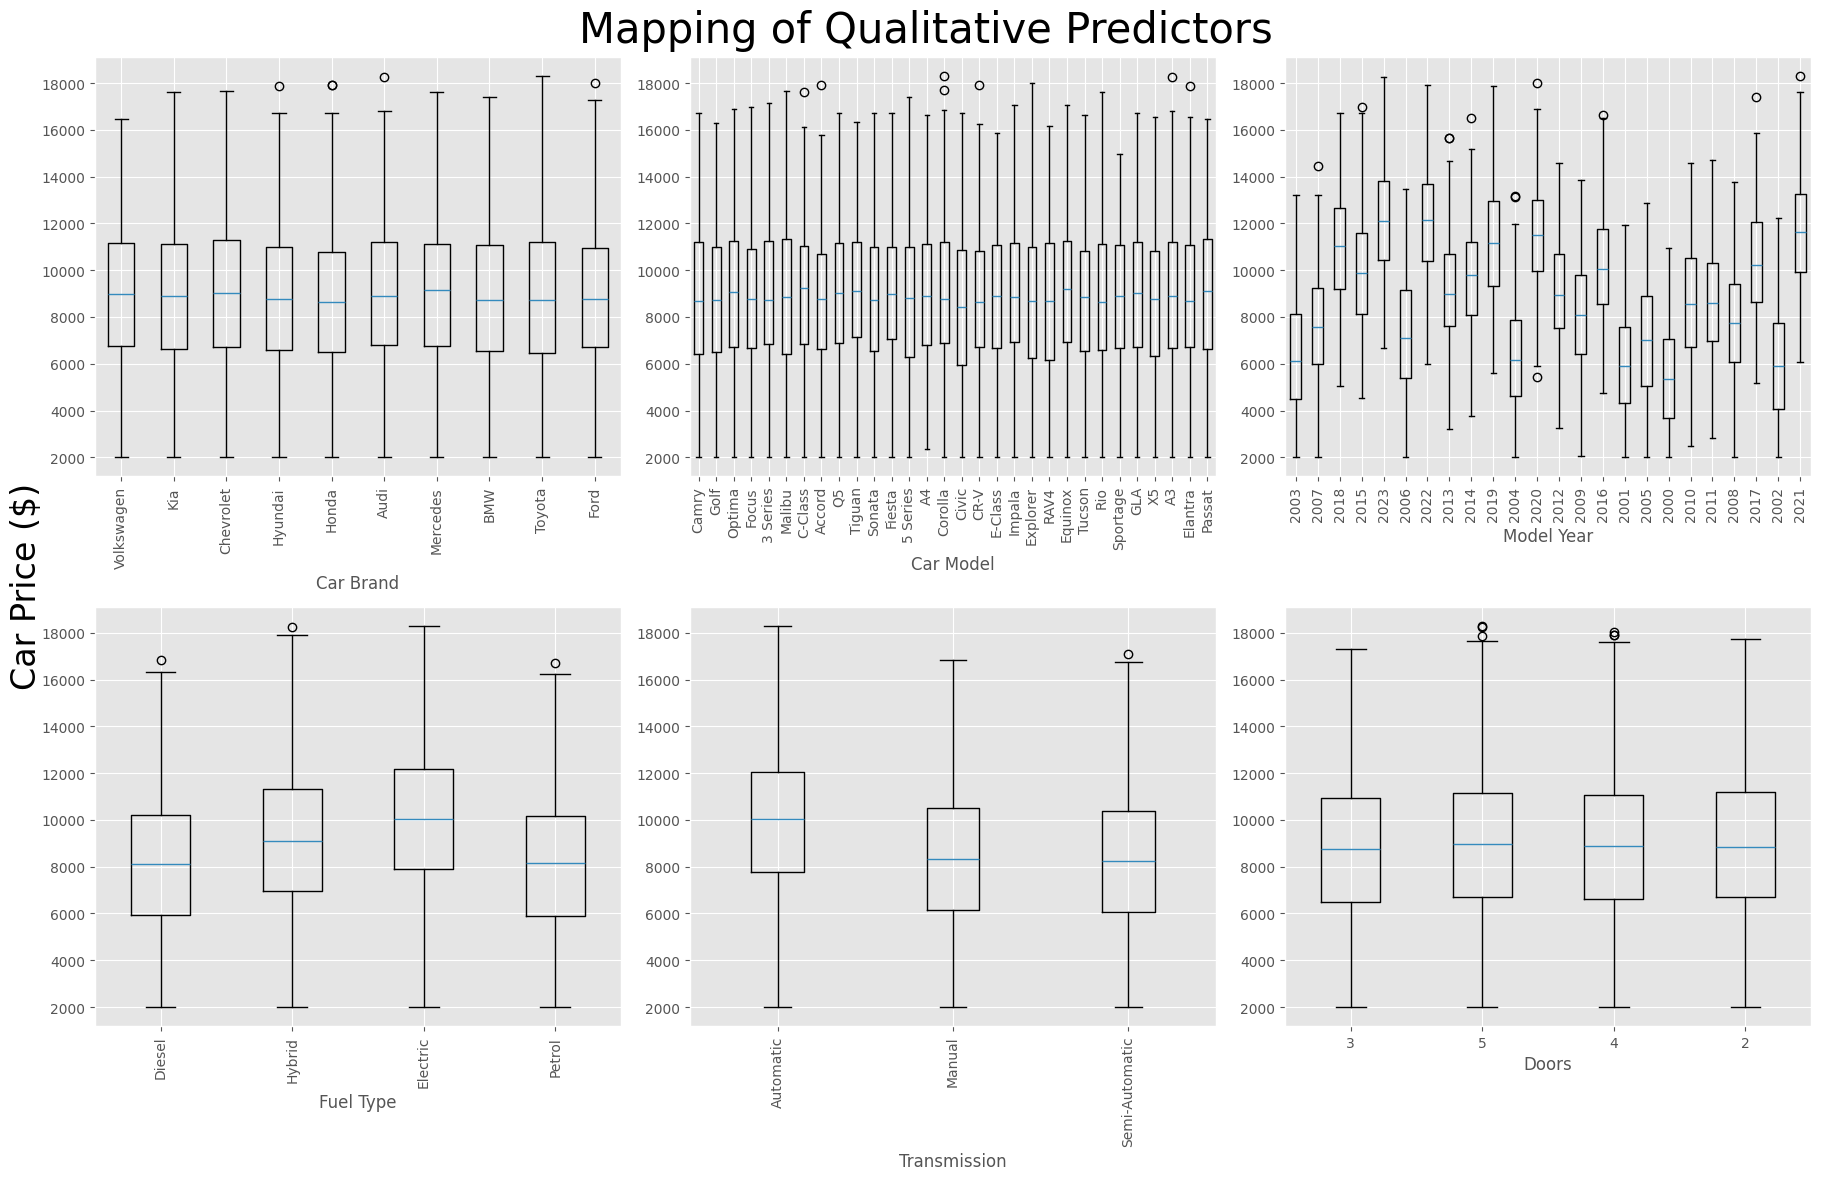

In [16]:
style.use('ggplot')

# create a grid for the boxplots
fig, axs = plt.subplots(2, 3, figsize = (18, 12))

# subset the qualitative predictors
qualitativePredictors = ["Brand", "Model", "Year", "Fuel_Type", "Transmission", "Doors"]
qualitativeData = carData.select(*qualitativePredictors, "Price")

# plot the car brands
groupedBrand = qualitativeData.groupBy("Brand").agg(F.collect_list("Price").alias("Price")).collect()
df_brandPlot = [row["Price"] for row in groupedBrand]


axs[0][0].boxplot(df_brandPlot)
axs[0][0].set_xticks(range(1, len(df_brandPlot) + 1), [row["Brand"] for row in groupedBrand], rotation = 90)
axs[0][0].set_xlabel("Car Brand")


# plot the car models
groupedModel = qualitativeData.groupBy("Model").agg(F.collect_list("Price").alias("Price")).collect()
df_carModelPlot = [row["Price"] for row in groupedModel]


axs[0][1].boxplot(df_carModelPlot)
axs[0][1].set_xticks(range(1, len(df_carModelPlot) + 1), [row['Model'] for row in groupedModel], rotation = 90)
axs[0][1].set_xlabel("Car Model")

# plot the model years
groupedYear = qualitativeData.groupBy("Year").agg(F.collect_list("Price").alias("Price")).collect()
df_yearPlot = [row["Price"] for row in groupedYear]


axs[0][2].boxplot(df_yearPlot)
axs[0][2].set_xticks(range(1, len(df_yearPlot) + 1), [row['Year'] for row in groupedYear], rotation = 90)
axs[0][2].set_xlabel("Model Year")

# plot the fuel types
groupedFuel = qualitativeData.groupBy("Fuel_Type").agg(F.collect_list("Price").alias("Price")).collect()
df_fuelPlot = [row["Price"] for row in groupedFuel]


axs[1][0].boxplot(df_fuelPlot)
axs[1][0].set_xticks(range(1, len(df_fuelPlot) + 1), [row["Fuel_Type"] for row in groupedFuel], rotation = 90)
axs[1][0].set_xlabel("Fuel Type")

# plot the transmission types
groupedTransmission = qualitativeData.groupBy("Transmission").agg(F.collect_list("Price").alias("Price")).collect()
df_transmissionPlot = [row["Price"] for row in groupedTransmission]


axs[1][1].boxplot(df_transmissionPlot)
axs[1][1].set_xticks(range(1, len(df_transmissionPlot) + 1), [row["Transmission"] for row in groupedTransmission], rotation = 90)
axs[1][1].set_xlabel("Transmission")

# plot the door count
groupedDoors = qualitativeData.groupBy("Doors").agg(F.collect_list("Price").alias("Price")).collect()
df_doorsPlot = [row["Price"] for row in groupedDoors]


axs[1][2].boxplot(df_doorsPlot)
axs[1][2].set_xticks(range(1, len(df_doorsPlot) + 1), [row["Doors"] for row in groupedDoors], rotation = 0)
axs[1][2].set_xlabel("Doors")

fig.suptitle("Mapping of Qualitative Predictors", fontsize = 30)
fig.text(0.0002, 0.5, "Car Price ($)", ha= "center", va= "center", rotation= "vertical", fontsize=24)

plt.tight_layout()
plt.show()

### Configure the Data for Model Building

The brand and model attributes are related to each other. Therefore, an interaction needs to be made.

In [17]:
# create the interaction between the car brand and model
carData = carData.withColumn("Make and Model", concat_ws("-", "Brand", "Model"))

# drop the original columns
carData = carData.drop("Brand", "Model")

#### Create Dummy Variables

In [18]:
# create dummy variables for make and model
uniqueMakeModel = [row["Make and Model"] for row in carData.select("Make and Model").distinct().collect()]

for makeAndModel in uniqueMakeModel:
    carData = carData.withColumn(f"Make and Model_{makeAndModel}", when(carData["Make and Model"] == makeAndModel, 1).otherwise(0))

## drop the first dummy
firstDummy_makeModel = f"Make and Model_{uniqueMakeModel[0]}"
print(f"Baseline: {firstDummy_makeModel}")
carData = carData.drop(firstDummy_makeModel)
carData = carData.drop("Make and Model")


# create dummy variables for year
uniqueYear = [row["Year"] for row in carData.select("Year").distinct().collect()]

for year in uniqueYear:
    carData = carData.withColumn(f"Year_{year}", when(carData["Year"] == year, 1).otherwise(0))

## drop the first dummy
firstDummy_year = f"Year_{uniqueYear[0]}"
print(f"Baseline: {firstDummy_year}")
carData = carData.drop(firstDummy_year)
carData = carData.drop("Year")


# create dummy variables for fuel
uniqueFuel = [row["Fuel_Type"] for row in carData.select("Fuel_Type").distinct().collect()]

for fuel in uniqueFuel:
    carData = carData.withColumn(f"Fuel_Type_{fuel}", when(carData["Fuel_Type"] == fuel, 1).otherwise(0))

## drop the first dummy
firstDummy_fuel = f"Fuel_Type_{uniqueFuel[0]}"
print(f"Baseline: {firstDummy_fuel}")
carData = carData.drop(firstDummy_fuel)
carData = carData.drop("Fuel_Type")

# create dummy variables for transmission
uniqueTransmission = [row["Transmission"] for row in carData.select("Transmission").distinct().collect()]

for transmission in uniqueTransmission:
    carData = carData.withColumn(f"Transmission_{transmission}", when(carData["Transmission"] == transmission, 1).otherwise(0))

## drop the first dummy
firstDummy_transmission = f"Transmission_{uniqueTransmission[0]}"
print(f"Baseline: {firstDummy_transmission}")
carData = carData.drop(firstDummy_transmission)
carData = carData.drop("Transmission")

# create dummy variables for doors
uniqueDoors = [row["Doors"] for row in carData.select("Doors").distinct().collect()]

for doors in uniqueDoors:
    carData = carData.withColumn(f"Doors_{doors}", when(carData["Doors"] == doors, 1).otherwise(0))

## drop the first dummy
firstDummy_doors = f"Doors_{uniqueDoors[0]}"
print(f"Baseline: {firstDummy_doors}")
carData = carData.drop(firstDummy_doors)
carData = carData.drop("Doors")

Baseline: Make and Model_BMW-3 Series
Baseline: Year_2003
Baseline: Fuel_Type_Diesel
Baseline: Transmission_Automatic
Baseline: Doors_3


#### Split the Data
We will split the data to use 70% for training, 15% for testing, and 15% for validation.

In [19]:
# create the testing data
trainData, remainingData = carData.randomSplit([.7, .3], seed = 1235)
# create the testing and validation data
testData, validationData = remainingData.randomSplit([.5, .5], seed = 1235)

#### Ridge Model

In [24]:
#   Ridge Regression (Spark MLlib)
#    keeps all predictors, shrinks β with L2 penalty
#    λ (regParam) tuned by 5‑fold cross‑validation


# ───────────────────────── 0. cache ─────────────────────────────
#trainData.cache().count()
#validationData.cache().count()

# ───────────────────────── 1. feature list ──────────────────────
label_col     = "Price"
numeric_cols  = ["Engine_Size", "Mileage", "Owner_Count"]
dummy_cols    = [c for c in trainData.columns
                 if c not in numeric_cols + [label_col]]
feature_cols  = numeric_cols + dummy_cols
print(f"{len(feature_cols)} total features")

# ───────────────────────── 2. pipeline stages ───────────────────
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

vec   = VectorAssembler(inputCols=feature_cols, outputCol="vec")
scl   = StandardScaler(inputCol="vec", outputCol="features")
ridge = LinearRegression(labelCol=label_col,
                         featuresCol="features",
                         elasticNetParam=0.0)        # pure Ridge

ridge_pipe = Pipeline(stages=[vec, scl, ridge])

# ───────────────────────── 3. hyper‑parameter grid ──────────────
param_grid = (ParamGridBuilder()
              .addGrid(ridge.regParam, [0.01, 0.1, 1.0, 10.0])
              .build())

rmse_eval = RegressionEvaluator(labelCol=label_col, metricName="rmse")
r2_eval   = RegressionEvaluator(labelCol=label_col, metricName="r2")

cv = CrossValidator(estimator=ridge_pipe,
                    estimatorParamMaps=param_grid,
                    evaluator=rmse_eval,
                    numFolds=5,
                    seed=42)

# ───────────────────────── 4. optional sampling for CV speed ────
sample_train = trainData.sample(0.30, seed=42)   # 30 % of rows
ridge_cv = cv.fit(sample_train)

best_lambda = ridge_cv.bestModel.stages[-1]._java_obj.getRegParam()
print(f"Best λ (regParam): {best_lambda}")

# ───────────────────────── 5. refit on full train ───────────────
final_vec  = VectorAssembler(inputCols=feature_cols, outputCol="vec")
final_scl  = StandardScaler(inputCol="vec", outputCol="features")
final_lr   = LinearRegression(labelCol=label_col,
                              featuresCol="features",
                              elasticNetParam=0.0,
                              regParam=best_lambda)

final_ridge = Pipeline(stages=[final_vec, final_scl, final_lr]).fit(trainData)

test_rmse = rmse_eval.evaluate(final_ridge.transform(testData))
test_r2   = r2_eval.evaluate(final_ridge.transform(testData))

print("Test RMSE        :", f"{test_rmse:,.2f}")
print("Test R²          :", f"{test_r2:.4f}")

63 total features
Best λ (regParam): 0.1
Test RMSE        : 84.52
Test R²          : 0.9993
